In [2]:
from definitions import *
from plots import *
from Experiment import *

%load_ext autoreload
%autoreload 2

In [3]:
exp_som = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, False, 'anomaly', 'JJA')


In [19]:
net, centers = exp_som.compute_som(6, 6, 150, False, False, True, inner_dist_type='grid', train_kwargs=dict(train_algo='batch', epochs=500))
projected = net.project_onto_map(net.data)
da_som = exp_som.open_da('anomaly', 'JJA')
indices = net.bmus
hs_mask = hotspells_mask(timerange=DATERANGEPL_SUMMER)
node_mask = indices[:, None] == np.arange(net.n_nodes)[None, :]
node_mask_da = xr.DataArray(node_mask, coords={'time': hs_mask.time, 'node': np.arange(net.n_nodes)})
populations = net.compute_populations()


2023-05-24 10:54:55.807 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-05-24 10:54:55.815 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-05-24 10:54:55.818 | WARNING  | simpsom.network:_set_weights:197 - Please be sure that the data have been standardized before using PCA.
2023-05-24 10:54:55.819 | INFO     | simpsom.network:_set_weights:200 - The weights will be initialized with PCA.
2023-05-24 10:54:55.962 | INFO     | simpsom.network:train:362 - The map will be trained with the batch algorithm.
  1%|▏         | 7/500 [00:35<41:22,  5.04s/it]


KeyboardInterrupt: 

# Plots

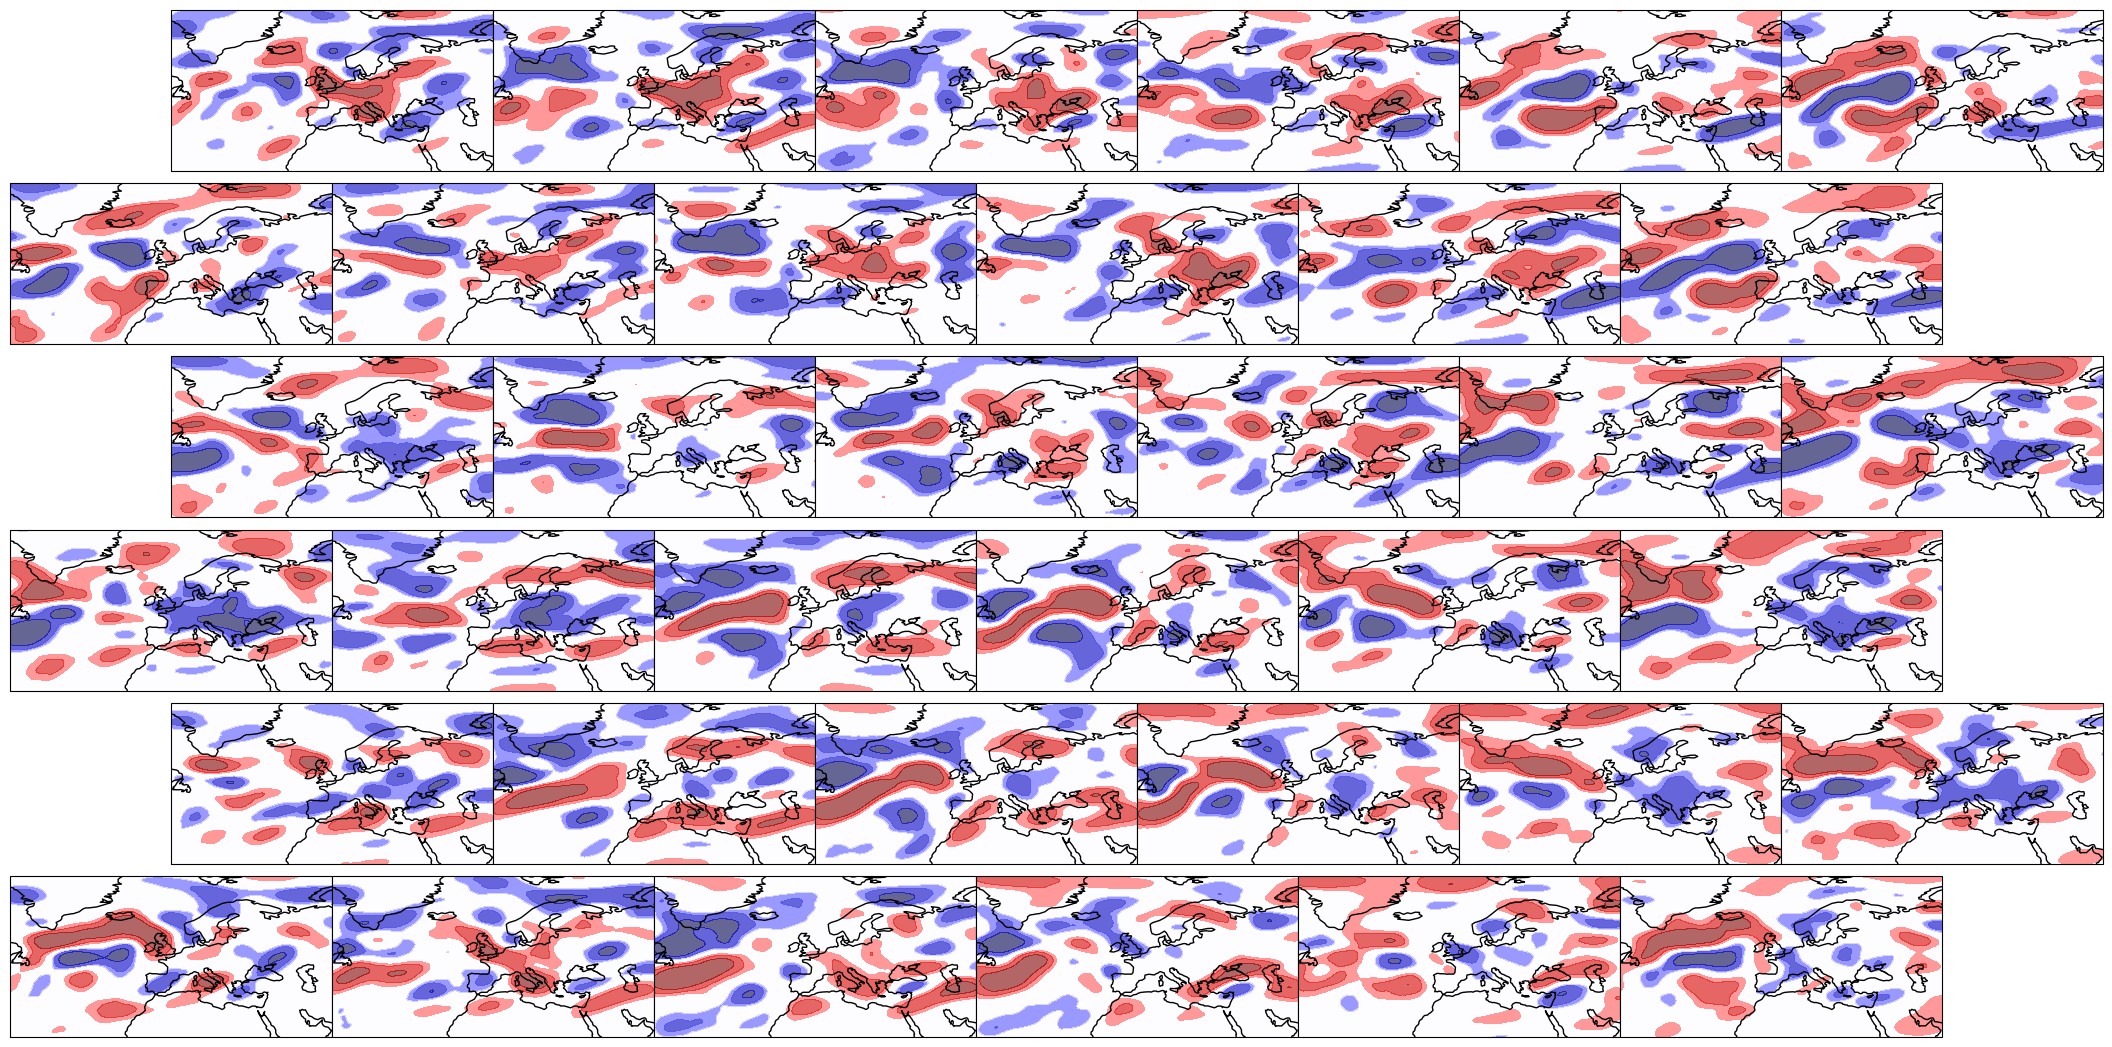

In [ ]:
ncol, nrow = net.width, net.height
lon = centers["lon"].values
lat = centers["lat"].values
ratio =  (lat[-1] - lat[0]) / (lon[-1] - lon[0])
fig, axes = honeycomb_panel(ncol, nrow, ratio, dict(projection=ccrs.PlateCarree()))
tbd = []
cmap_wind = mpl.colormaps['seismic']
qlist = [0.025, 0.1, 0.2, 0.8, 0.9, .975]
levels_wind = centers.quantile(qlist).values
norm_wind = BoundaryNorm(levels_wind, cmap_wind.N, extend='both')

for n, (i, j) in enumerate(product(range(ncol), range(nrow))):
    ax = axes[i, j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(
        lon, lat, centers.isel(x=i, y=j), cmap=cmap_wind, levels=levels_wind, norm=norm_wind, extend='both', alpha=0.6
    )
    ax.add_feature(COASTLINE)


In [12]:
centers = exp_som.cluster(4, 150)

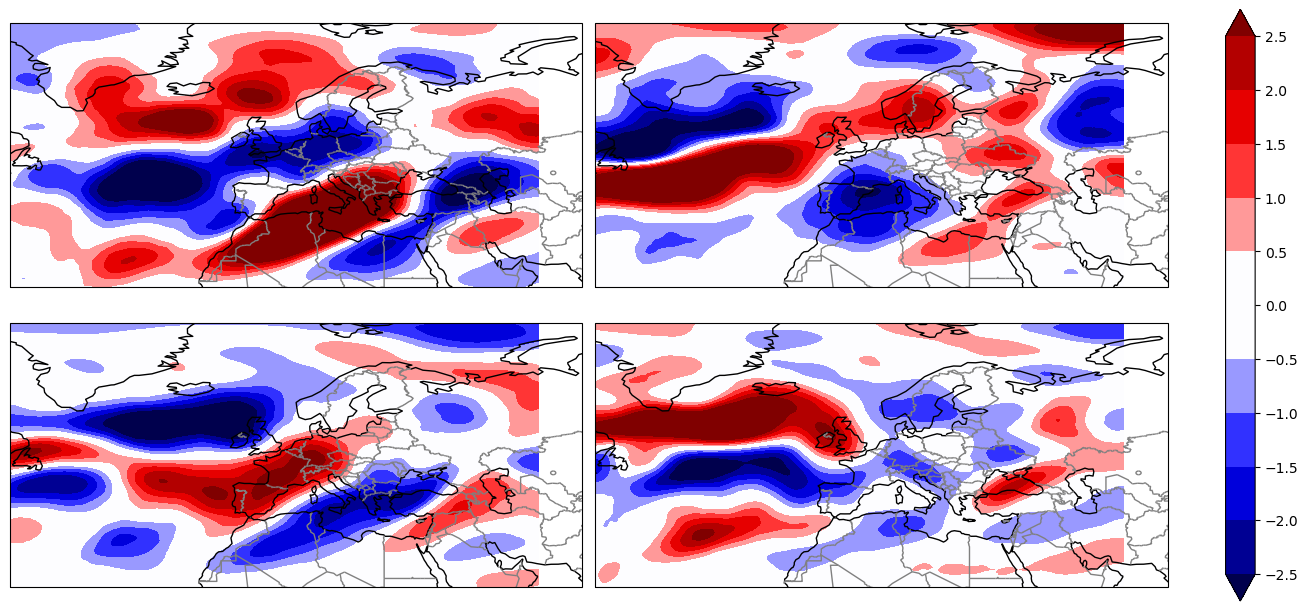

In [17]:
clu = Clusterplot(2, 2)
clu.add_contourf(centers[0])

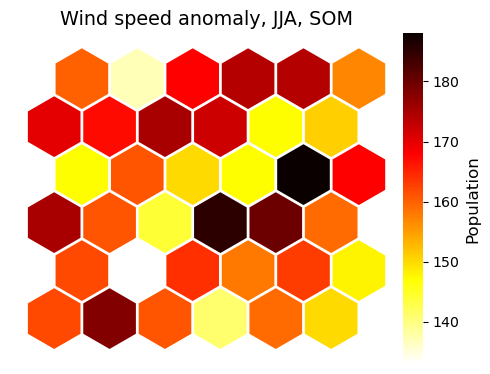

In [5]:
cmap = mpl.colormaps["hot"].reversed()
populations = net.compute_populations()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Population",
    "title": "Wind speed anomaly, JJA, SOM",
}
fig, ax = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=True,
    **kwargs
)

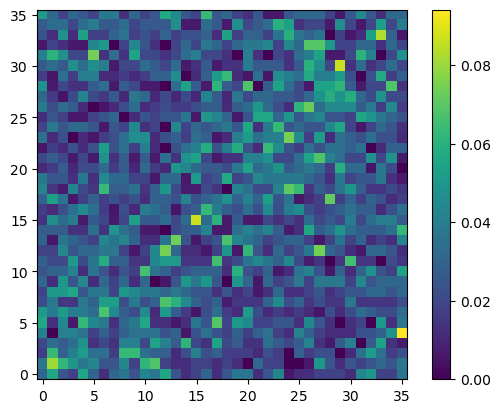

In [6]:
trans_mat = net.compute_transmat(step=3)
fig, ax = plt.subplots()
im = ax.imshow(trans_mat, origin="lower")
fig.colorbar(im, ax=ax)


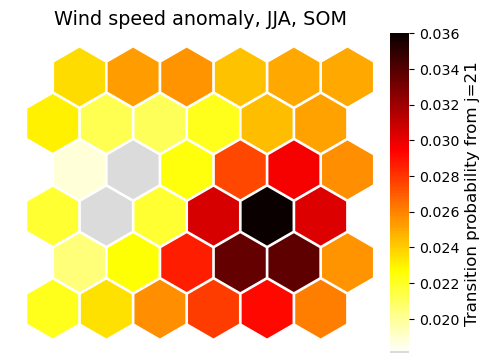

In [7]:
cmap = mpl.colormaps["hot"].reversed()(np.linspace(0, 1, 128))
cmap[:1, :3] = (np.asarray([220, 220, 220]) / 256)[None, :]
cmap = ListedColormap(cmap)
j = np.random.randint(0, net.width * net.height)
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Transition probability from {j=}",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}
probas = trans_mat[:, j]
fig, ax = net.plot_on_map(
    probas,
    smooth_sigma=1,
    show=True,
    **kwargs
)


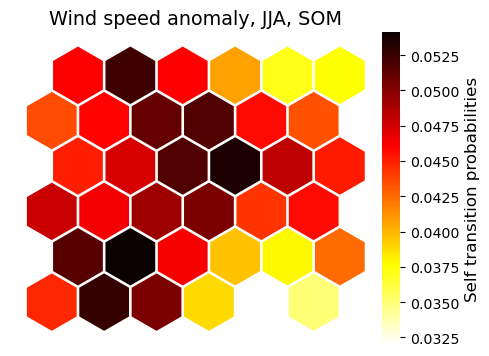

In [8]:
cmap = mpl.colormaps["hot"].reversed()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Self transition probabilities",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    np.diag(trans_mat),
    smooth_sigma=1,
    show=True,
    **kwargs
)

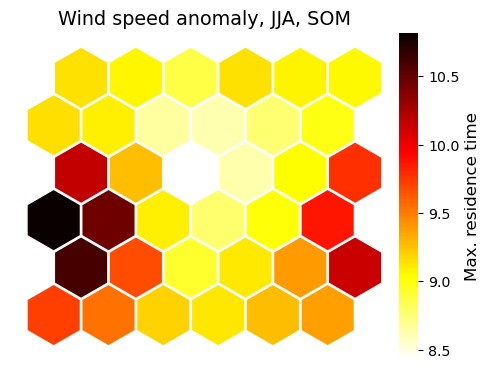

In [9]:
rt_max = net.compute_residence_time('max', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Max. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    **kwargs
)

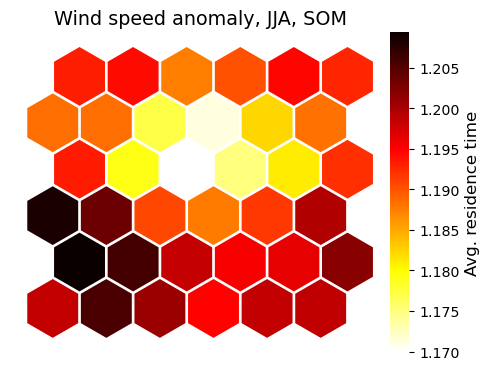

In [10]:
rt_max = net.compute_residence_time('mean', smooth_sigma=0)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Avg. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    **kwargs
)

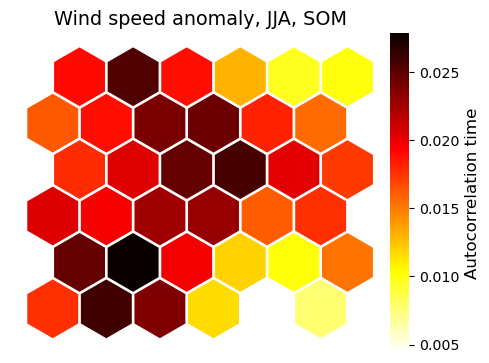

In [11]:
acorr = net.compute_autocorrelation(lag_max=30)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Autocorrelation time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    acorr[3, :],
    smooth_sigma=1,
    **kwargs
)

# SOM vs hotspells

## conditional probas

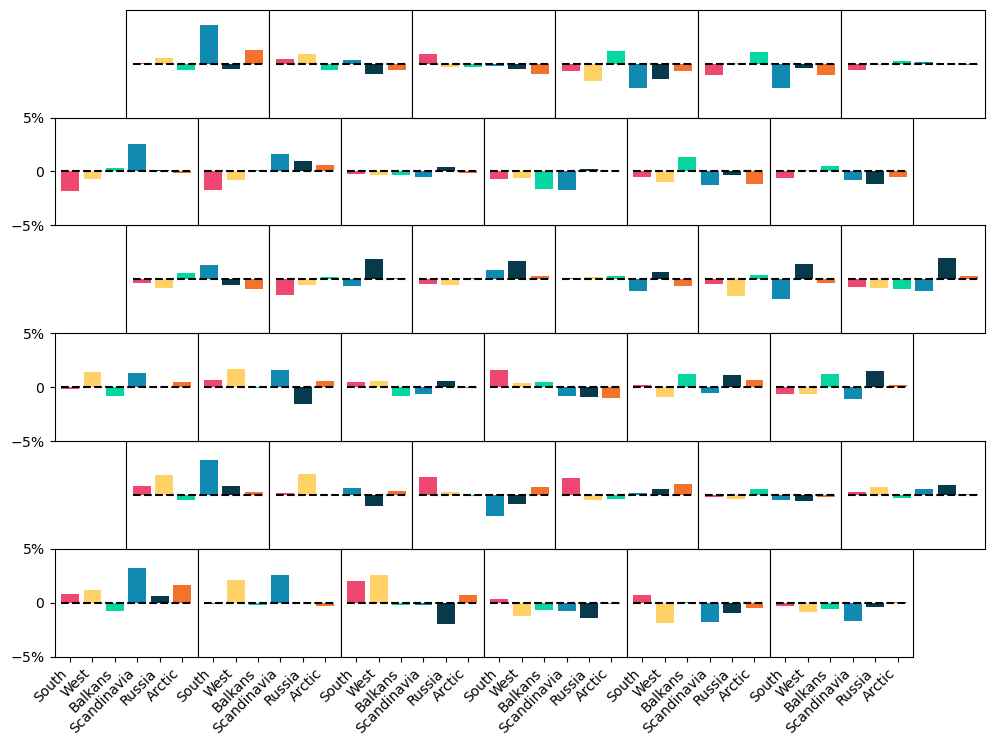

In [13]:
lag = 1
probas = np.sum(np.roll(node_mask[lag:, :, None], shift=lag, axis=0) & hs_mask.values[lag:, None, :], axis=0) / np.sum(hs_mask.values, axis=0)[None, :]
probas -= populations[:, None] / np.sum(populations)
fig, axes = honeycomb_panel(net.width, net.height)
for ax, proba in zip(axes.flatten(), probas):
    ax.bar(np.arange(6), proba, color=COLORS5)
    ax.plot([- 0.4, 5.4], [0, 0], color='black', ls='dashed', zorder=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([-0.05, 0.05])
for ax in axes[0, ::2]:
    ax.set_yticks([-0.05, 0., 0.05], [r'$-5\%$', r'$0$', r'$5\%$'])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(6), REGIONS, rotation=45, ha='right')

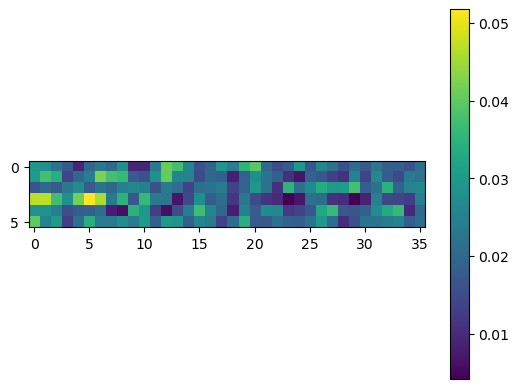

In [14]:
im = plt.imshow(np.sum(hs_mask.values[:, :, None] & node_mask[:, None, :], axis=0) / np.sum(hs_mask.values[:, :, None] | node_mask[:, None, :], axis=0))
plt.colorbar(im)

# lagged time series

In [15]:
hotspells, maxnhs, maxlen = get_hostpells_v2()
node_mask_da_hs = apply_hotspells_mask_v2(hotspells, node_mask_da, maxlen, maxnhs)

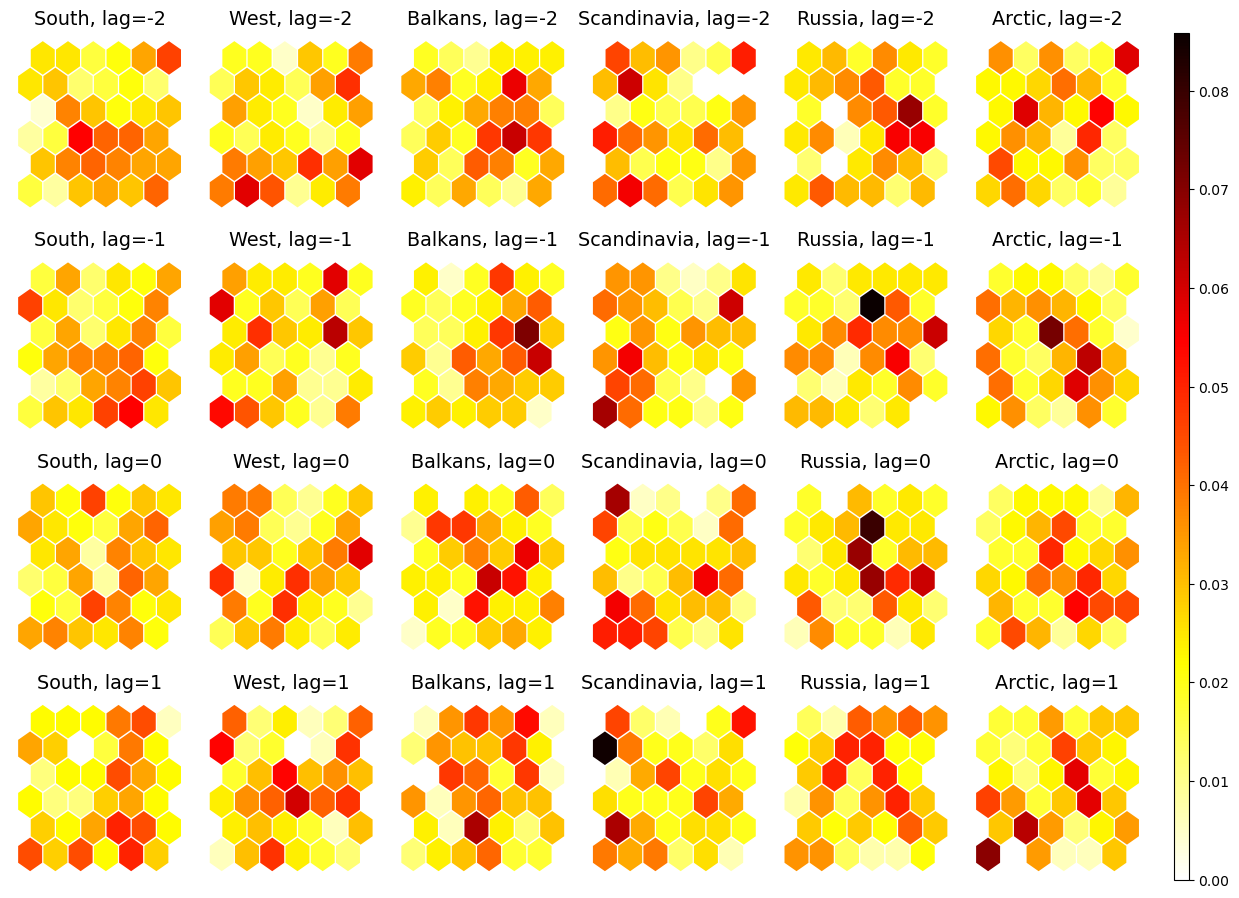

In [16]:
lags = [-2, -1, 0, 1]
to_plot = node_mask_da_hs.sel(day_after_beg=lags).mean(dim='hotspell')
kwargs = {
    "cmap": mpl.colormaps["hot"].reversed(),
    "norm": Normalize(vmin=0, vmax=to_plot.max())
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
fig, axes = plt.subplots(len(lags), len(REGIONS), figsize=(14, 9))
for ilag, lag in enumerate(lags):
    for ax, region in zip(axes[ilag], REGIONS):
        kwargs['title'] = f'{region}, {lag=}'
        fig, ax = net.plot_on_map(
            to_plot.sel(region=region, day_after_beg=lag),
            smooth_sigma=0,
            fig=fig,
            ax=ax,
            show=False,
            draw_cbar=False,
            **kwargs
        )
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.02, aspect=60)
plt.show()

# SOM vs Zoo

In [17]:
varnames = ['Lat', 'Int', 'Tilt', 'Dep', 'Mea']
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
Zoo = Zoo[varnames].isel(time=Zoo.time.dt.season=='JJA')
mu = Zoo.mean(dim='time')
sigma = Zoo.std(dim='time', ddof=1)
node_mask = indices[:, None] == np.arange(net.n_nodes)[None, :]
node_mask_da = xr.DataArray(node_mask, coords={'time': Zoo.time, 'node': np.arange(net.n_nodes)})

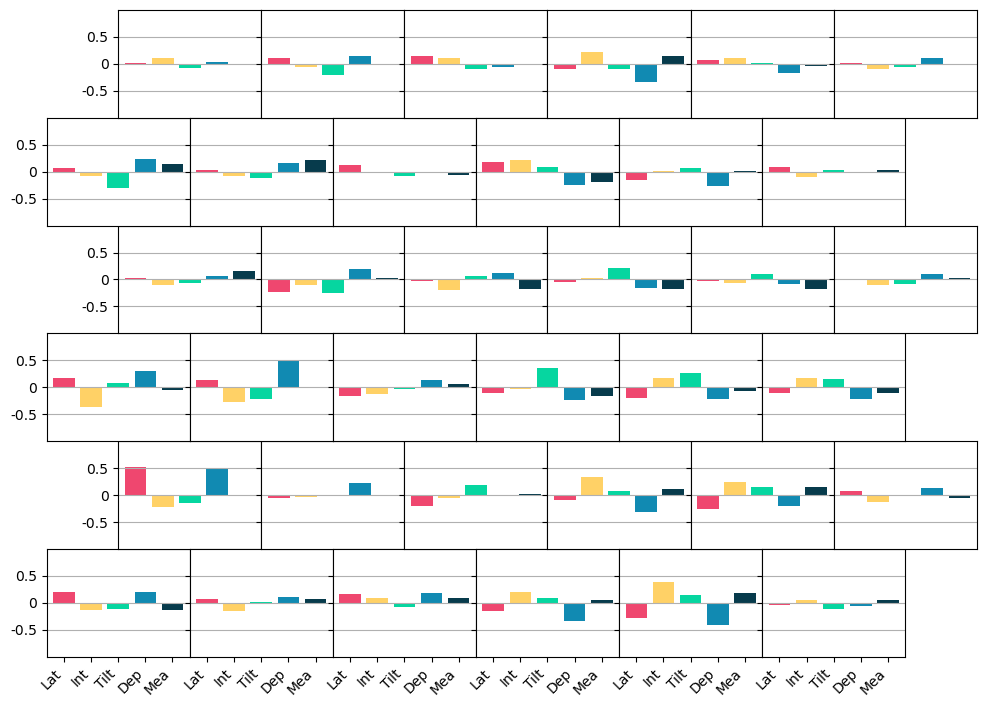

In [18]:
fig, axes = honeycomb_panel(net.width, net.height)
for ax, mask in zip(axes.flatten(), node_mask.T):
    thismu = Zoo.isel(time=mask).mean(dim='time')
    to_plot = [(thismu[vn] - mu[vn]) / sigma[vn] for vn in varnames]
    ax.bar(np.arange(len(varnames)), to_plot, color=COLORS5, label=varnames)
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([-0.5, 0, 0.5], [''] * 3)
    ax.grid(True, axis='y')
for ax in axes[0, :]:
    ax.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(5), varnames, rotation=45, ha='right')

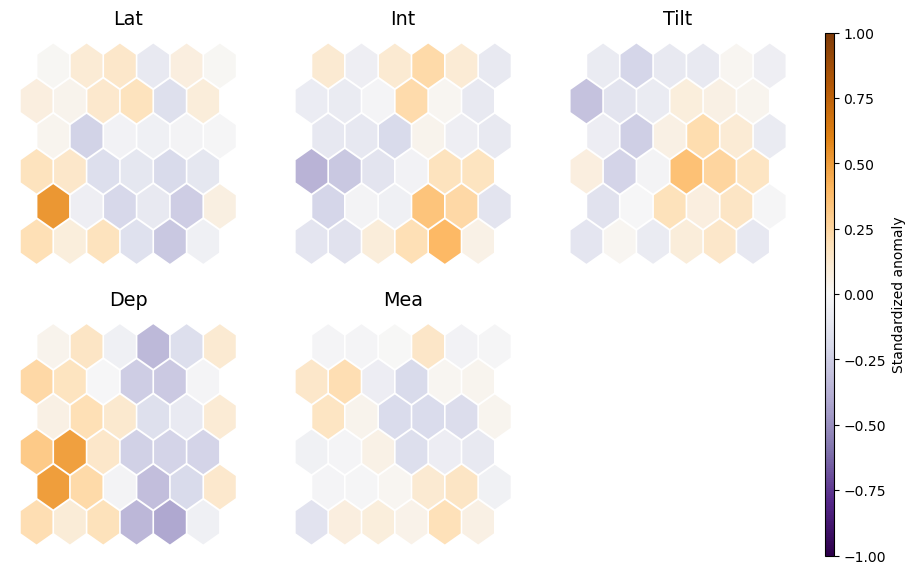

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
mean_on_node = xr.concat([Zoo.isel(time=mask).mean(dim='time') for mask in node_mask.T], dim='node')
axes = axes.flatten()
kwargs = {
    "cmap": mpl.colormaps["PuOr"].reversed(),
    "norm": Normalize(vmin=-1, vmax=1),
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
for ax, varname in zip(axes[:-1], varnames):
    kwargs['title'] = varname
    thismu = Zoo[varname].mean(dim='time')
    to_plot = (mean_on_node[varname] - mu[varname]) / sigma[varname]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        fig=fig,
        ax=ax,
        show=False,
        draw_cbar=False,
        **kwargs
    )
axes[-1].set_visible(False)
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.03, aspect=60, label='Standardized anomaly')
plt.show()

# SOM vs T anomaly

In [5]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
# da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
da_s = exp_som.open_da('anomaly', 'JJA')


In [6]:
multimask = (indices[:, None] == np.arange(net.n_nodes)[None, :]).reshape(-1, net.width, net.height)

In [7]:
coords = {
    'x': centers['x'],
    'y': centers['y'],
    'lat': da_T['lat'],
    'lon': da_T['lon']
}
center_temps = xr.DataArray(np.empty((net.width, net.height, *da_T.shape[1:])), coords=coords)
for i, j in product(range(net.width), range(net.height)):
    center_temps[i, j] = da_T.isel(time=multimask[:, i, j]).mean(dim='time')

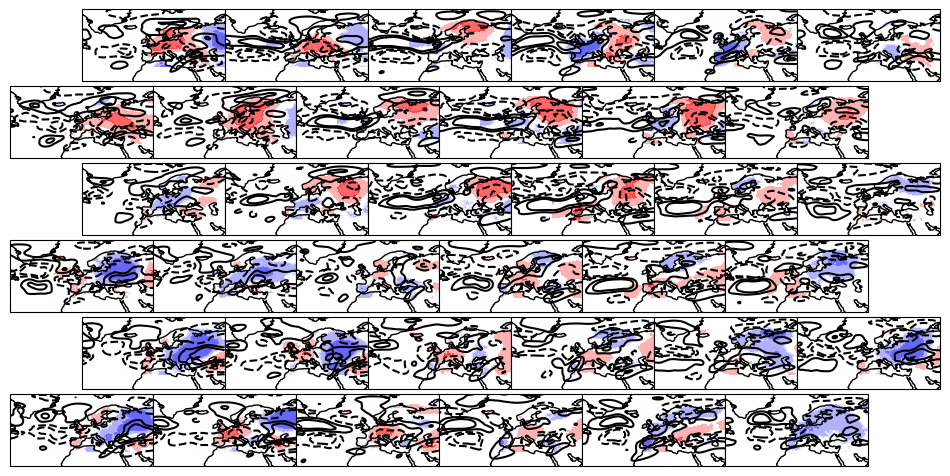

In [8]:
ncol, nrow = net.width, net.height
ratio = (da_som.lat[-1] - da_som.lat[0]) / (da_som.lon[-1] - da_som.lon[0])  * nrow / ncol
fig, axes = honeycomb_panel(ncol, nrow, ratio, dict(projection=ccrs.PlateCarree()))
tbd = []
lont = center_temps["lon"].values
latt = center_temps["lat"].values
lonw = centers["lon"].values
latw = centers["lat"].values
cmap_temp = mpl.colormaps['bwr']
cmap_wind = mpl.colormaps['BrBG']
qlist = [0.025, 0.15, 0.85, .975]
levels_temp = center_temps.quantile(qlist).values
norm_temp = BoundaryNorm(levels_temp, cmap_temp.N, extend='both')
levels_wind = centers.quantile(qlist).values

for n, (i, j) in enumerate(product(range(ncol), range(nrow))):
    ax = axes[i, j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(
        lont, latt, center_temps.isel(x=i, y=j), cmap=cmap_temp, levels=levels_temp, norm=norm_temp, extend='both', alpha=0.6
    )
    ax.contour(
        lonw, latw, centers.isel(x=i, y=j), levels=levels_wind, colors='black', linewidths=1.5,
    )
    ax.add_feature(COASTLINE)
# if i % 2 == 0:
#     tbd.append(fig.add_subplot(gs[i, -1]).set_visible(False))
# else:
#     tbd.append(fig.add_subplot(gs[i, 0]).set_visible(False))


## Intransivity

In [84]:
allnodes = np.arange(net.n_nodes)
indices_mask = indices[:, None] == allnodes[None, :]
indices_mask = xr.DataArray(indices_mask, coords={'time': da_som.time.values, 'node': allnodes})

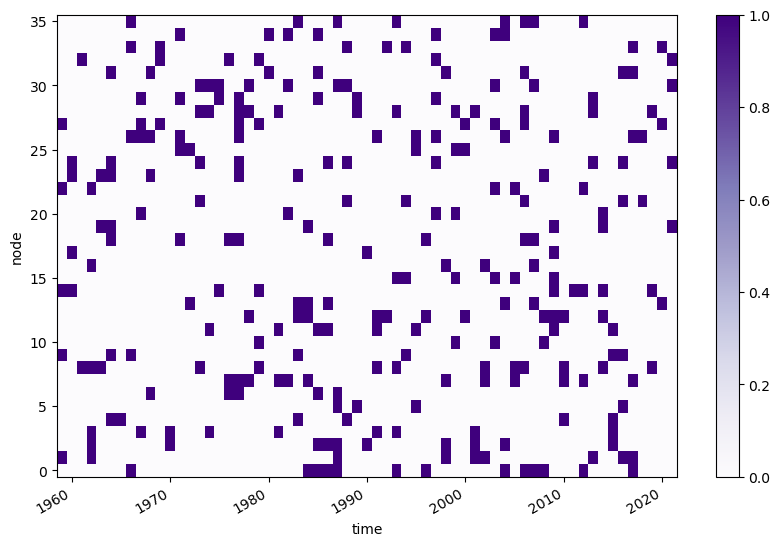

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list(
    "gr",
    [
        [21 / 256, 176 / 256, 26 / 256, 1],
        [1, 1, 1, 1],
        [229 / 256, 0, 0, 1],
    ],
    N=50,
)
to_plot = indices_mask.resample(time='1YS').any(dim='time').T
(~to_plot).plot.pcolormesh(cmap='Purples') #, linewidth=.5, edgecolors='white')
